Import packages

In [263]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from tabulate import tabulate

Load data

In [264]:
df = pd.read_csv('elliptic_txs_features.csv', header=None)
df_edgelist = pd.read_csv('elliptic_txs_edgelist.csv')
df_classes = pd.read_csv('elliptic_txs_classes.csv')

## 1. Data cleaning

Rename columns

In [265]:
colNames1 = {'0': 'txId', 1: "Timestep"}
colNames2 = {str(i+2): "local" + str(i+1) for i in range(93)}
colNames3 = {str(i+95): "aggregated" + str(i+1) for i in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(j): item_kk for j,item_kk in colNames.items()} 

df = df.rename(columns=colNames)

Rename unknown class and check shapes

In [266]:
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = 3
print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edgelist.shape)
print('Shape of features', df.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


Check for missing values

In [267]:
# Function to calculate total missing values and percentage
def calculate_missing(df):
    total_missing = df.isna().sum().sum()
    total_cells = df.size
    percentage_missing = (total_missing / total_cells) * 100
    return total_missing, percentage_missing

# Check for missing values in each DataFrame
missing_values_info = []

# For the first DataFrame (df)
missing_values_df, percentage_missing_df = calculate_missing(df)
missing_values_info.append(('df', missing_values_df, f"{percentage_missing_df:.2f}%"))

# For the second DataFrame (df_edgelist)
missing_values_df_edgelist, percentage_missing_df_edgelist = calculate_missing(df_edgelist)
missing_values_info.append(('df_edgelist', missing_values_df_edgelist, f"{percentage_missing_df_edgelist:.2f}%"))

# For the third DataFrame (df_classes)
missing_values_df_classes, percentage_missing_df_classes = calculate_missing(df_classes)
missing_values_info.append(('df_classes', missing_values_df_classes, f"{percentage_missing_df_classes:.2f}%"))

# Create a table using tabulate
print(tabulate(missing_values_info, headers=['DataFrame', 'Total Missing Values', 'Percentage Missing'], tablefmt='psql'))

+-------------+------------------------+----------------------+
| DataFrame   |   Total Missing Values | Percentage Missing   |
|-------------+------------------------+----------------------|
| df          |                      0 | 0.00%                |
| df_edgelist |                      0 | 0.00%                |
| df_classes  |                      0 | 0.00%                |
+-------------+------------------------+----------------------+


Merge the classes to the data

In [268]:
df = pd.merge(df, df_classes)

## 2. EDA

Plot of the distrbution of the classes

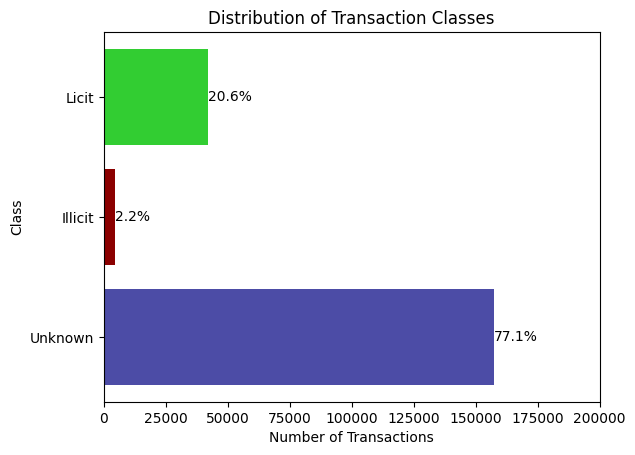

In [269]:
# Custom color palette
colors = [(0, 0, 0.5, 0.7), 'darkred', 'limegreen']

# Grouping by class and counting occurrences
group_class = df_classes.groupby('class').count()

# Calculate total transactions
total_transactions = group_class['txId'].sum()

# Calculate percentages
percentages = (group_class['txId'] / total_transactions) * 100

# Plotting
bars = plt.barh(['Unknown', 'Illicit', 'Licit'], group_class['txId'].values, color=colors)

# Annotate percentages on bars
for bar, p, prc in zip(bars, group_class['txId'].values, percentages):
    plt.text(p, bar.get_y() + bar.get_height()/2, f'{prc:.1f}%', ha='left', va='center', fontsize=10)

# Adding labels and title
plt.xlabel('Number of Transactions')
plt.ylabel('Class')
plt.title('Distribution of Transaction Classes')

# Show plot
plt.xlim(0, 200000)
plt.show()

Plot of the transactions per timestep

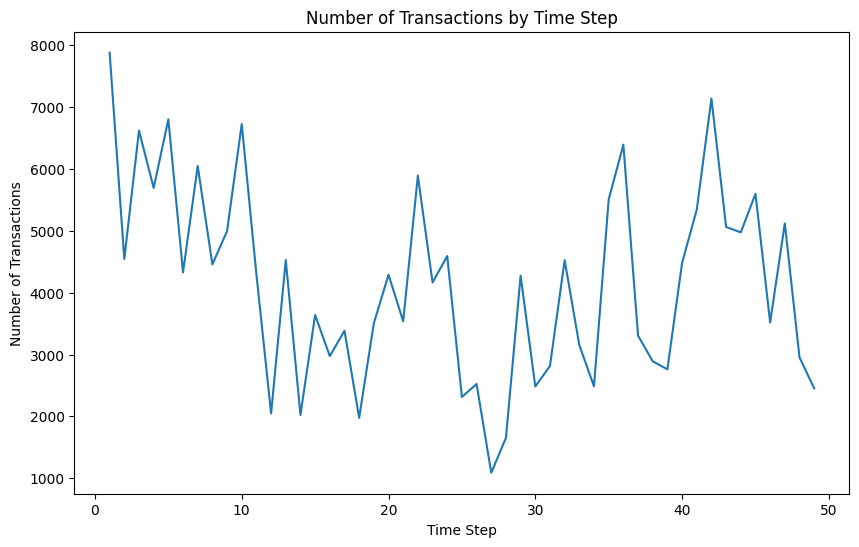

In [270]:
# Grouping by time step and counting occurrences
group_feature = df.groupby(df['Timestep']).count()

# Plotting
group_feature['txId'].plot(figsize=(10, 6))

# Adding labels and title
plt.title('Number of Transactions by Time Step')
plt.xlabel('Time Step')
plt.ylabel('Number of Transactions')

# Show plot
plt.show()

Plot of the transactions per timestep per class

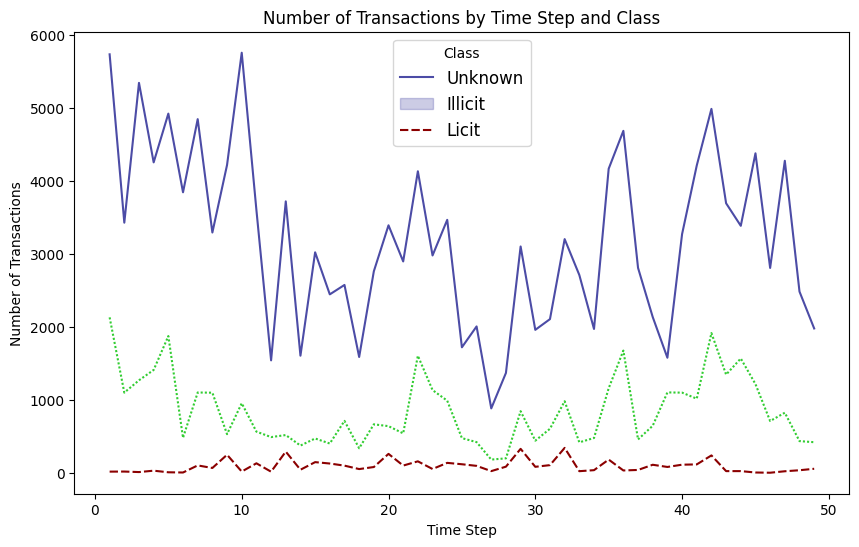

In [271]:
# Grouping by time step and counting occurrences for each class
grouped_df = df.groupby(['Timestep', 'class']).size().unstack(fill_value=0)

# Create figure and axes for line plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting line plot
sns.lineplot(data=grouped_df, palette=colors, ax=ax)

# Adding labels and title
plt.title('Number of Transactions by Time Step and Class')
plt.xlabel('Time Step')
plt.ylabel('Number of Transactions')

# Customize legend
plt.legend(['Unknown', 'Illicit', 'Licit'], title='Class', fontsize=12)

# Show plot
plt.show()

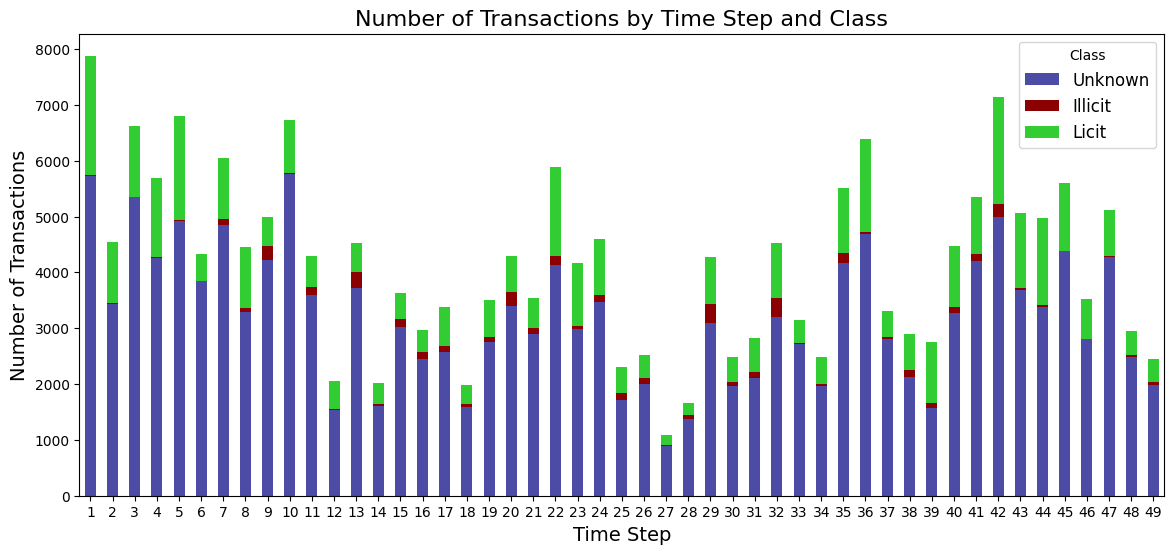

In [272]:
# Create figure and axes for bar plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plotting bar plot
grouped_df.plot(kind='bar', stacked=True, color=colors, ax=ax)

# Adding labels and title
plt.title('Number of Transactions by Time Step and Class', fontsize=16)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.xticks(rotation=0) 

# Customize legend
plt.legend(['Unknown', 'Illicit', 'Licit'], title='Class', fontsize=12)

# Show plot
plt.show()


Find the most occuring illicit counts per timestep

In [273]:
# Filter DataFrame for illicit transactions
illicit_df = df[df['class'] == '1']

# Group by time step and count occurrences
illicit_count = illicit_df.groupby('Timestep').size()

# Find the three time steps with the highest illicit transaction count
highest_counts = illicit_count.nlargest(3)

# Find the three time steps with the lowest illicit transaction count
lowest_counts = illicit_count.nsmallest(3)

# Convert the series to a DataFrame for tabulation
table_highest = highest_counts.reset_index()
table_highest.columns = ['Time Step', 'Illicit Transaction Count (Highest)']

table_lowest = lowest_counts.reset_index()
table_lowest.columns = ['Time Step', 'Illicit Transaction Count (Lowest)']

# Print tables using tabulate
print("Three time steps with the highest illicit transaction count:")
print(tabulate(table_highest, headers='keys', tablefmt='psql', showindex=False))
print("\nThree time steps with the lowest illicit transaction count:")
print(tabulate(table_lowest, headers='keys', tablefmt='psql', showindex=False))

Three time steps with the highest illicit transaction count:
+-------------+---------------------------------------+
|   Time Step |   Illicit Transaction Count (Highest) |
|-------------+---------------------------------------|
|          32 |                                   342 |
|          29 |                                   329 |
|          13 |                                   291 |
+-------------+---------------------------------------+

Three time steps with the lowest illicit transaction count:
+-------------+--------------------------------------+
|   Time Step |   Illicit Transaction Count (Lowest) |
|-------------+--------------------------------------|
|          46 |                                    2 |
|           6 |                                    5 |
|          45 |                                    5 |
+-------------+--------------------------------------+


Plot the illicit transaction using the edgelist data

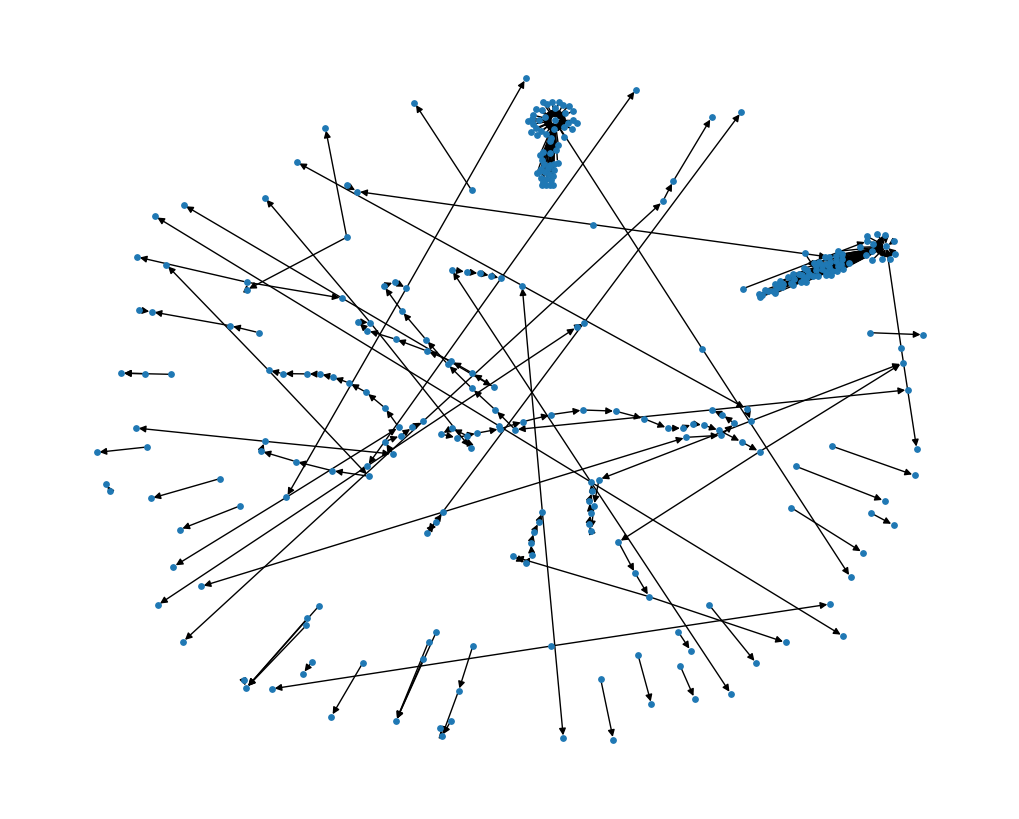

In [274]:
# Filter illicit transactions for time step 32
illicit_ids = df.loc[(df['Timestep'] == 32) & (df['class'] == '1'), 'txId']
illicit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(illicit_ids)]

# Create a directed graph from the DataFrame
graph = nx.from_pandas_edgelist(illicit_edges, source='txId1', target='txId2', create_using=nx.DiGraph())

# Layout for the graph
pos = nx.spring_layout(graph)

# Set the figure size directly in NetworkX
plt.figure(figsize=(10, 8))

# Draw the graph with smaller node size
nx.draw(graph, with_labels=False, pos=pos, node_size=15)

# Show the plot
plt.show()

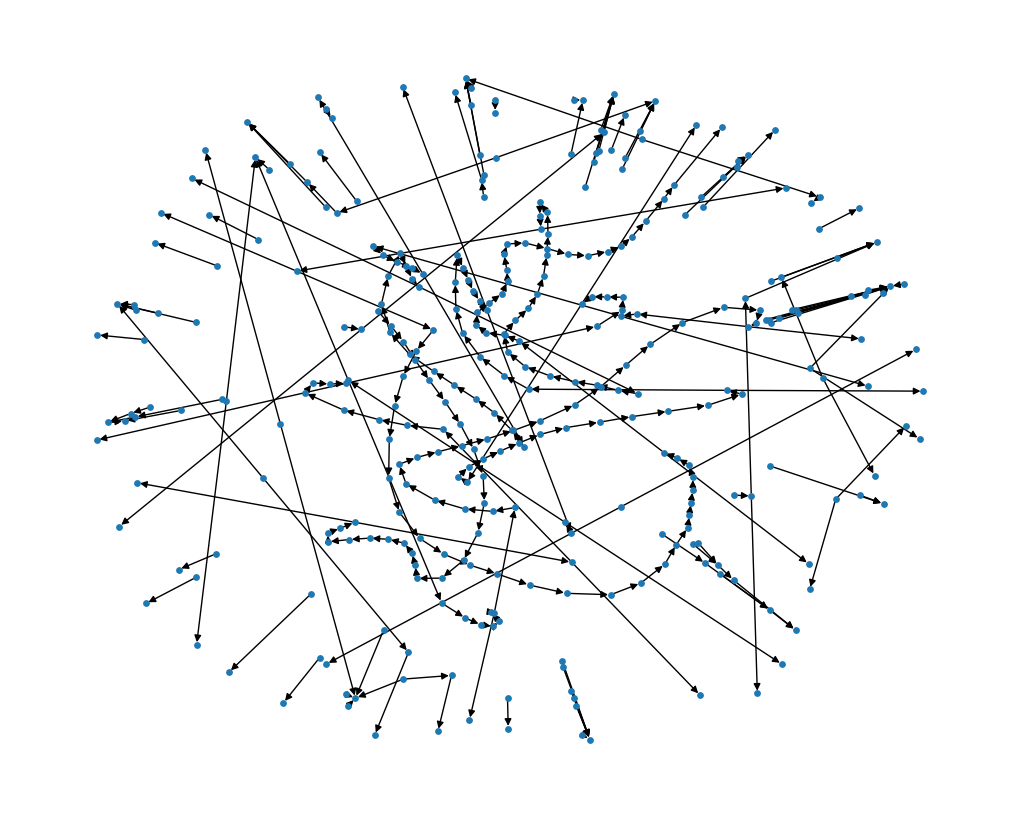

In [275]:
# Filter illicit transactions for time step 32
illicit_ids = df.loc[(df['Timestep'] == 29) & (df['class'] == '1'), 'txId']
illicit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(illicit_ids)]

# Create a directed graph from the DataFrame
graph = nx.from_pandas_edgelist(illicit_edges, source='txId1', target='txId2', create_using=nx.DiGraph())

# Layout for the graph
pos = nx.spring_layout(graph)

# Set the figure size directly in NetworkX
plt.figure(figsize=(10, 8))

# Draw the graph with smaller node size
nx.draw(graph, with_labels=False, pos=pos, node_size=15)

# Show the plot
plt.show()

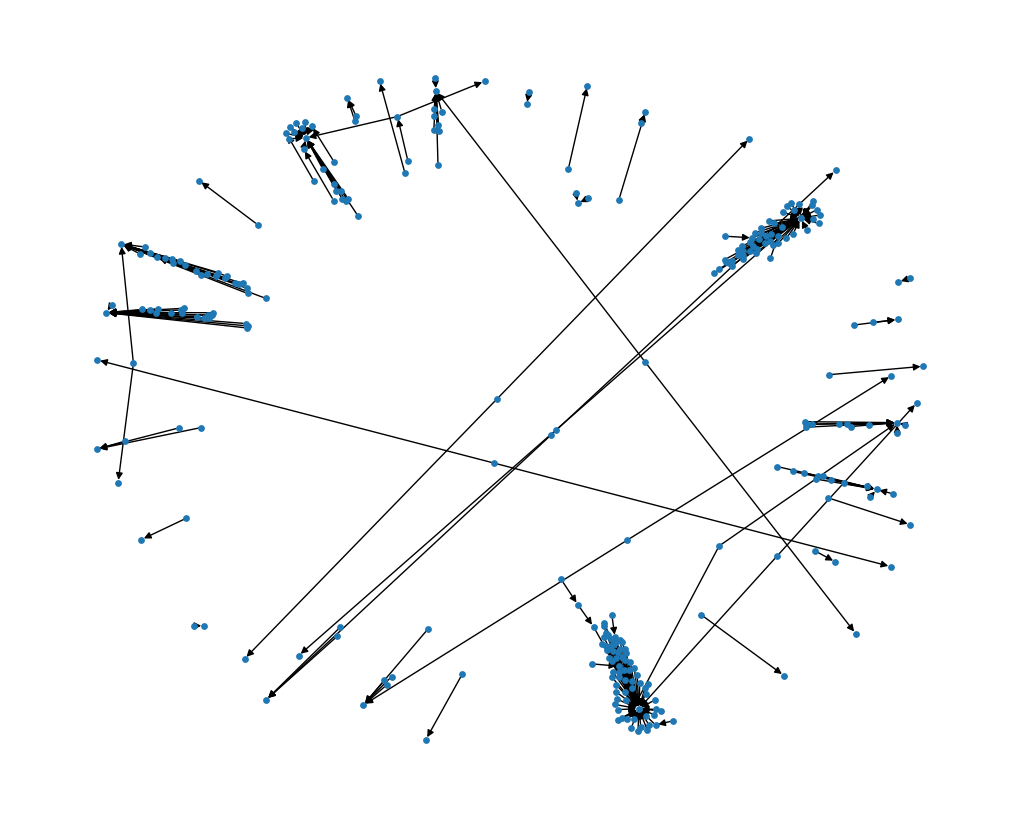

In [276]:
# Filter illicit transactions for time step 32
illicit_ids = df.loc[(df['Timestep'] == 13) & (df['class'] == '1'), 'txId']
illicit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(illicit_ids)]

# Create a directed graph from the DataFrame
graph = nx.from_pandas_edgelist(illicit_edges, source='txId1', target='txId2', create_using=nx.DiGraph())

# Layout for the graph
pos = nx.spring_layout(graph)

# Set the figure size directly in NetworkX
plt.figure(figsize=(10, 8))

# Draw the graph with smaller node size
nx.draw(graph, with_labels=False, pos=pos, node_size=15)

# Show the plot
plt.show()

## 3. Feature engineering

In [277]:
# Rename the 'class' column to 'class_'
df.rename(columns={'class': 'class_'}, inplace=True)

In [278]:
class TrainTestSplitter(object):
    '''Class to perform the split of the data into train, test, and validation.
    '''
    def __init__(self, train_frac=0.8, validation_frac=0.2, seed=1234):
        self.train_frac = train_frac
        self.validation_frac = validation_frac
        self.seed = seed

    def split_train_test(self, df):
        print("Generating the train/validation/test splits...")
        self.total_n_illicit = df.loc[lambda x: x.class_ == 1].shape[0]
        self.total_n_licit = df.loc[lambda x: x.class_ == 2].shape[0]
        self.total_n_unknown = df.loc[lambda x: x.class_ == 3].shape[0]
        self.train_set = df.sample(frac=self.train_frac, random_state=self.seed)
        self.test_set = df.loc[lambda x: ~x.txId.isin(self.train_set.txId)].reset_index(drop=True)
        self.validation_set = self.train_set.sample(frac=self.validation_frac).reset_index(drop=True)
        self.train_set = self.train_set.loc[lambda x: ~x.txId.isin(self.validation_set.txId)].reset_index(drop=True)
        print("split completed")

In [279]:
# create a fitting_splits object that will hold the train, validation, and test data
fitting_splits = TrainTestSplitter()

In [280]:
fitting_splits.split_train_test(df)

Generating the train/validation/test splits...


calculating the statistics...
split completed


In [282]:
# Prepare all the data for subsequent use
# Training Set
X_train = fitting_splits.train_set

# Drop unnecessary columns from the training set
X_train = X_train.drop(['txId', 'class_'], axis=1)

# Extract the target variable for the training set (square root of selling price)
y_train = fitting_splits.train_set['class_']

# Validation Set
X_validation = fitting_splits.validation_set

# Drop unnecessary columns from the validation set
X_validation = X_validation.drop(['txId', 'class_'], axis=1)

# Extract the target variable for the validation set (square root of selling price)
y_validation = fitting_splits.validation_set["class_"]

# Test Set
X_test = fitting_splits.test_set

# Drop unnecessary columns from the test set
X_test = X_test.drop(['txId', 'class_'], axis=1)

# Extract the target variable for the test set (square root of selling price)
y_test = fitting_splits.test_set["class_"]

# Combine Training and Validation Sets for Cross-Validation
X_train_validation = pd.concat([X_train, X_validation])
y_train_validation = pd.concat([y_train, y_validation])

In [283]:
# Assuming your dataset is stored in a DataFrame called df
count_train = y_train.value_counts()
percent_train = count_train / len(y_train) * 100
table_train = pd.DataFrame({'Count': count_train, 'Percentage': percent_train})

count_val = y_validation.value_counts()
percent_val = count_val / len(y_validation) * 100
table_val = pd.DataFrame({'Count': count_val, 'Percentage': percent_val})

count_test = y_test.value_counts()
percent_test = count_test / len(y_test) * 100
table_test = pd.DataFrame({'Count': count_test, 'Percentage': percent_test})

print("Training Data:")
print(tabulate(table_train, headers='keys', tablefmt='psql'))
print("\nValidation Data:")
print(tabulate(table_val, headers='keys', tablefmt='psql'))
print("\nTest Data:")
print(tabulate(table_test, headers='keys', tablefmt='psql'))

Training Data:
+----+---------+--------------+
|    |   Count |   Percentage |
|----+---------+--------------|
|  3 |  100526 |     77.0834  |
|  2 |   26982 |     20.6898  |
|  1 |    2904 |      2.22679 |
+----+---------+--------------+

Validation Data:
+----+---------+--------------+
|    |   Count |   Percentage |
|----+---------+--------------|
|  3 |   25214 |     77.3364  |
|  2 |    6663 |     20.4368  |
|  1 |     726 |      2.22679 |
+----+---------+--------------+

Test Data:
+----+---------+--------------+
|    |   Count |   Percentage |
|----+---------+--------------|
|  3 |   31465 |     77.2071  |
|  2 |    8374 |     20.5477  |
|  1 |     915 |      2.24518 |
+----+---------+--------------+


In [284]:
X_validation.shape

(32603, 166)

In [285]:
X_test.shape

(40754, 166)

In [286]:
y_train

0         3
1         3
2         3
3         2
4         3
         ..
130407    2
130408    3
130409    3
130410    3
130411    3
Name: class_, Length: 130412, dtype: object